In [1]:
import math
from math import *
import random
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.stats import kstest
import statsmodels.api as sm
from tqdm import tqdm
from pyts.decomposition import SingularSpectrumAnalysis
from statsmodels.sandbox.regression.gmm import GMM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
vix = pd.read_csv('daily vix history.csv',header=None)
vix.columns = 'Date','VIX'
vix['Date'] = pd.to_datetime(vix['Date'].astype('str'))

In [3]:
vix

,Date,VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26
...,...,...
8182,2022-06-24,27.23
8183,2022-06-27,26.95
8184,2022-06-28,28.36
8185,2022-06-29,28.16


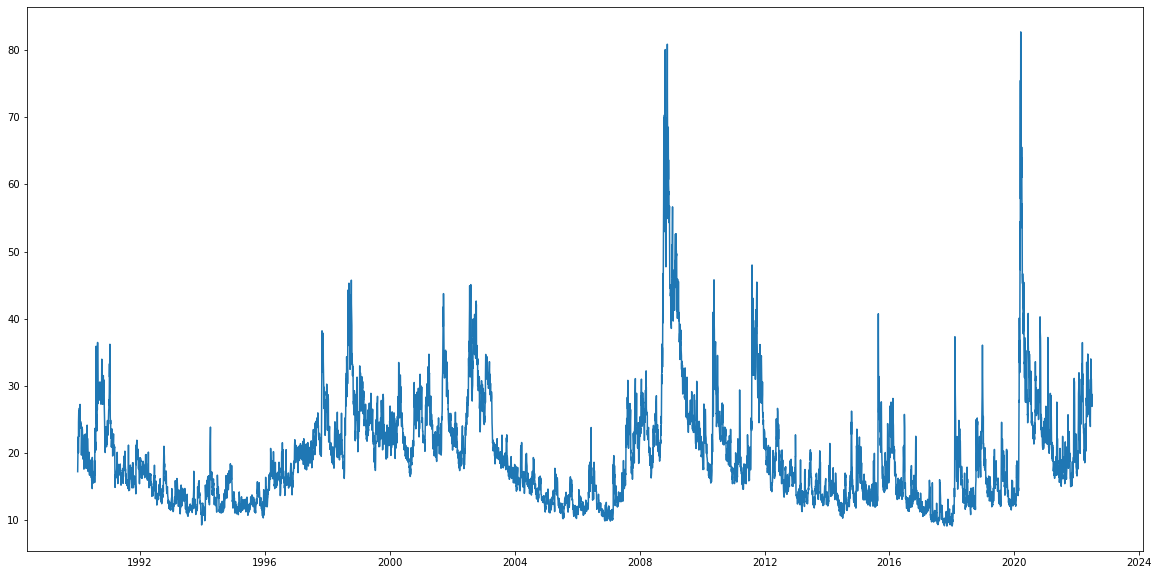

In [4]:
plt.figure(figsize = (20, 10))
plt.plot(vix['Date'],vix['VIX'])
plt.show()

# Find Spike

Three requirement of spikes:
1) The percentage change of VIX during the past 5(window1) trading days is higher than 30%(threshold).\
2) The value of VIX at the spike date is the highest one during the past 5(window1) trading days.\
3) The number of days between spikes should be larger than 7(window2).

In [5]:
def SpikeDate(date,data,threshold,window1,window2):
    
    vix_change = data.pct_change(periods=window1-1)
    # relative changes that are larger than the threshold
    test1 = vix_change > threshold  
    # the spike date must be the one that has the largest value during the past few days
    test2 = (data.rolling(window1).max() == data) 
    pot_spk = date[test1&test2]  # all potential spike dates 
    
    date_change = (pot_spk.shift(-1) - pot_spk).dt.days # the days between this spike and next spike
    test3 = date_change >= window2  # whether the days between two potential spikes are larger than window2
    spike_date = pot_spk[test3]
    
    return spike_date

In [6]:
threshold = 0.3
window1 = 5
window2 = 7
spk_date = SpikeDate(vix.Date,vix.VIX,threshold,window1,window2)

In [7]:
spk = vix.iloc[spk_date.index]
spk

,Date,VIX
140,1990-07-23,23.68
150,1990-08-06,35.91
163,1990-08-23,36.47
411,1991-08-19,21.19
474,1991-11-15,21.18
...,...,...
7988,2021-09-20,25.71
8039,2021-12-01,31.12
8076,2022-01-25,31.16
8090,2022-02-14,28.33


In [8]:
vix['Year'] = vix.Date.dt.year
spk['Year'] = spk.Date.dt.year
spk_number = spk.groupby('Year')['VIX'].count()
spk_mean = spk_number.mean()
spk_mean # the average number of spikes per year

3.064516129032258

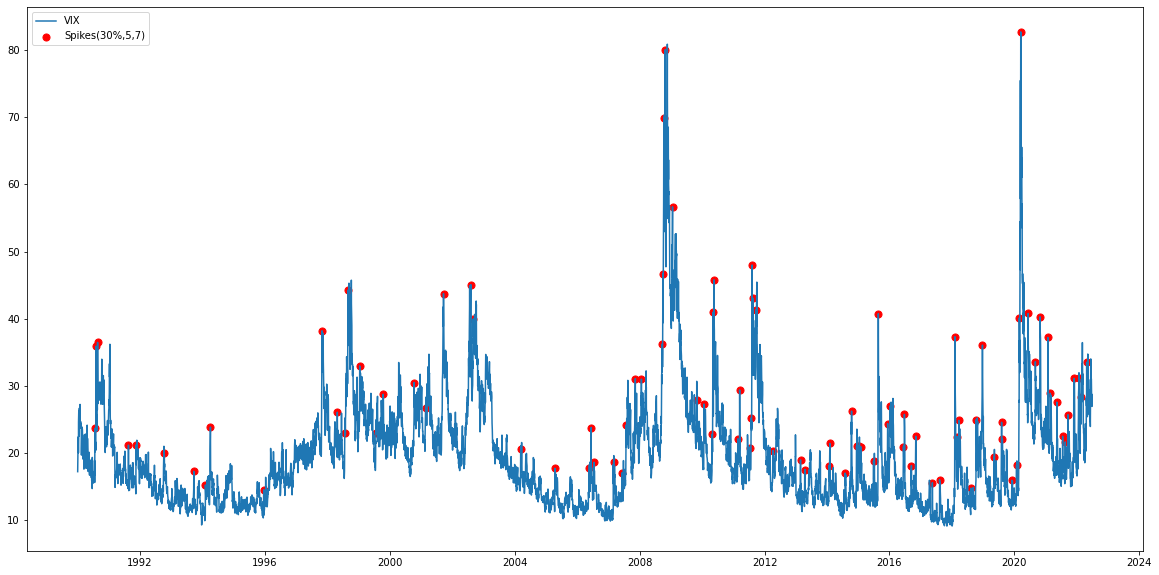

In [9]:
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],vix['VIX'],label='VIX')
plt.scatter(spk['Date'],spk['VIX'],s=50, color='red',label='Spikes(30%,5,7)')
plt.legend(loc=2)
plt.show()

# Speed of Decay

### Simple Moving Average (SMA)

In [10]:
# Find the simple moving average of all periods
vix['SMA_3'] = vix.VIX.rolling(63, min_periods=1).mean()
vix

,Date,VIX,Year,SMA_3
0,1990-01-02,17.24,1990,17.240000
1,1990-01-03,18.19,1990,17.715000
2,1990-01-04,19.22,1990,18.216667
3,1990-01-05,20.11,1990,18.690000
4,1990-01-08,20.26,1990,19.004000
...,...,...,...,...
8182,2022-06-24,27.23,2022,26.985873
8183,2022-06-27,26.95,2022,27.113651
8184,2022-06-28,28.36,2022,27.256984
8185,2022-06-29,28.16,2022,27.377619


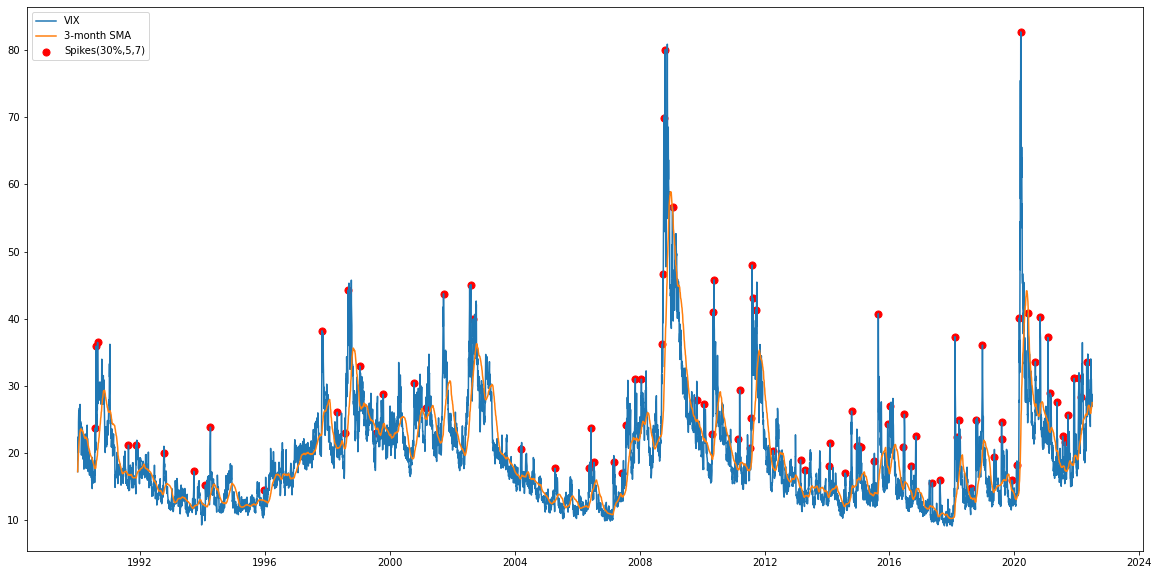

In [11]:
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],vix['VIX'],label='VIX')
plt.plot(vix['Date'],vix['SMA_3'],label='3-month SMA')
plt.scatter(spk['Date'],spk['VIX'],s=50, color='red',label='Spikes(30%,5,7)')
plt.legend(loc = 2)
plt.show()

### Exponential Moving Average

In [12]:
# Calculate the halflife of the VIX time series by Ornstein–Uhlenbeck process
VIX_lag = vix.VIX.shift(1)
VIX_lag[0] = VIX_lag[1]

VIX_ret = vix.VIX - VIX_lag
VIX_ret[0] = VIX_ret[1]

# Add intercept terms to X variable for regression
VIX_lag2 = sm.add_constant(VIX_lag)

model = sm.OLS(VIX_ret,VIX_lag2)
res = model.fit()

halflife = round(-np.log(2) / res.params[1],0)
halflife

32.0

In [13]:
# Find the exponential moving average of all periods with a half life of 32
vix['EMA_3'] = vix.VIX.ewm(halflife=32, adjust=False).mean()
vix

,Date,VIX,Year,SMA_3,EMA_3
0,1990-01-02,17.24,1990,17.240000,17.240000
1,1990-01-03,18.19,1990,17.715000,17.260357
2,1990-01-04,19.22,1990,18.216667,17.302348
3,1990-01-05,20.11,1990,18.690000,17.362510
4,1990-01-08,20.26,1990,19.004000,17.424597
...,...,...,...,...,...
8182,2022-06-24,27.23,2022,26.985873,26.907800
8183,2022-06-27,26.95,2022,27.113651,26.908704
8184,2022-06-28,28.36,2022,27.256984,26.939802
8185,2022-06-29,28.16,2022,27.377619,26.965948


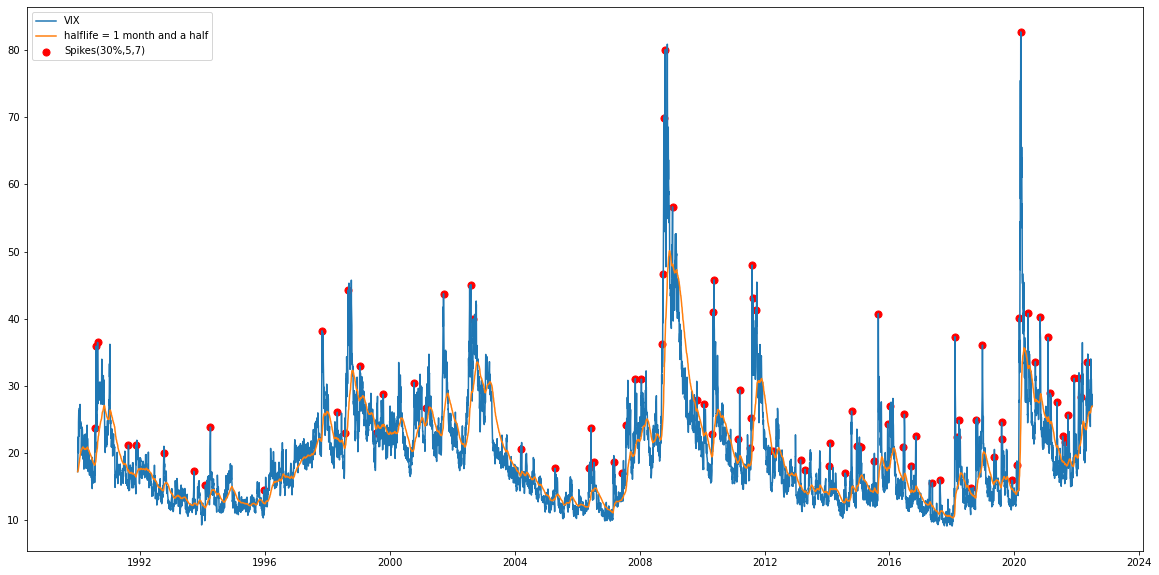

In [14]:
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],vix['VIX'],label='VIX')
plt.plot(vix['Date'],vix['EMA_3'],label='halflife = 1 month and a half')
plt.scatter(spk['Date'],spk['VIX'],s=50, color='red',label='Spikes(30%,5,7)')
plt.legend(loc = 2)
plt.show()

## Linear Decay

In [15]:
# Find the intersections between the VIX timeseries and the MA line

# For simple moving average
idx_SMA = np.argwhere(np.diff(np.sign(vix.VIX - vix.SMA_3))).flatten()
# For exponential moving average
idx_EMA = np.argwhere(np.diff(np.sign(vix.VIX - vix.EMA_3))).flatten()

In [16]:
SMA3 = vix.loc[idx_SMA][['Date','VIX','SMA_3']]
EMA3 = vix.loc[idx_EMA][['Date','VIX','EMA_3']]

spk_SMA3 = spk.copy()
spk_SMA3['after_spk_date'] = np.nan
spk_SMA3['SMA3'] = np.nan

spk_EMA3 = spk.copy()
spk_EMA3['after_spk_date'] = np.nan
spk_EMA3['EMA3'] = np.nan

In [17]:
for ind in spk_SMA3.index:
    after_spk = SMA3[(SMA3.Date > spk_SMA3.Date.loc[ind]).cumsum() == 1]
    spk_SMA3['after_spk_date'].loc[ind] = after_spk.Date.iloc[0]
    spk_SMA3['SMA3'].loc[ind] = after_spk.SMA_3.iloc[0]

In [18]:
for ind in spk_EMA3.index:
    after_spk = EMA3[(EMA3.Date > spk_EMA3.Date.loc[ind]).cumsum() == 1]
    spk_EMA3['after_spk_date'].loc[ind] = after_spk.Date.iloc[0]
    spk_EMA3['EMA3'].loc[ind] = after_spk.EMA_3.iloc[0]

In [19]:
spk_SMA3['after_spk_date'] = pd.to_datetime(spk_SMA3['after_spk_date'])
spk_SMA3['delta_vix'] =  spk_SMA3['VIX'] - spk_SMA3['SMA3']
spk_SMA3['days'] = (spk_SMA3['after_spk_date'] - spk_SMA3['Date']).dt.days
spk_SMA3['decay_rate'] = spk_SMA3['delta_vix']/spk_SMA3['days']
spk_SMA3 = spk_SMA3.drop_duplicates(subset=['SMA3'], keep='last')
spk_SMA3

,Date,VIX,Year,after_spk_date,SMA3,delta_vix,days,decay_rate
163,1990-08-23,36.47,1990,1990-10-18,28.077778,8.392222,56,0.149861
411,1991-08-19,21.19,1991,1991-08-20,16.820635,4.369365,1,4.369365
474,1991-11-15,21.18,1991,1991-12-20,17.396984,3.783016,35,0.108086
697,1992-10-05,20.01,1992,1992-11-04,15.449524,4.560476,30,0.152016
940,1993-09-21,17.30,1993,1993-09-30,12.126825,5.173175,9,0.574797
...,...,...,...,...,...,...,...,...
7988,2021-09-20,25.71,2021,2021-09-23,17.907302,7.802698,3,2.600899
8039,2021-12-01,31.12,2021,2021-12-09,19.613333,11.506667,8,1.438333
8076,2022-01-25,31.16,2022,2022-02-07,21.538889,9.621111,13,0.740085
8090,2022-02-14,28.33,2022,2022-03-17,24.883175,3.446825,31,0.111188


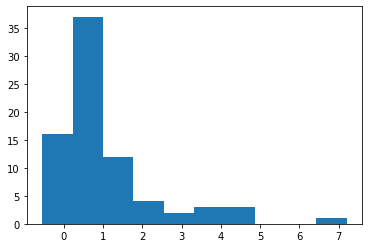

In [20]:
plt.figure()
plt.hist(spk_SMA3['decay_rate'])
plt.show()

In [21]:
spk_EMA3['after_spk_date'] = pd.to_datetime(spk_EMA3['after_spk_date'])
spk_EMA3['delta_vix'] =  spk_EMA3['VIX'] - spk_EMA3['EMA3']
spk_EMA3['days'] = (spk_EMA3['after_spk_date'] - spk_EMA3['Date']).dt.days
spk_EMA3['decay_rate'] = spk_EMA3['delta_vix']/spk_EMA3['days']
spk_EMA3 = spk_EMA3.drop_duplicates(subset=['EMA3'], keep='last')
spk_EMA3

,Date,VIX,Year,after_spk_date,EMA3,delta_vix,days,decay_rate
163,1990-08-23,36.47,1990,1990-11-08,27.088217,9.381783,77,0.121841
411,1991-08-19,21.19,1991,1991-08-20,17.436973,3.753027,1,3.753027
474,1991-11-15,21.18,1991,1991-12-13,17.639452,3.540548,28,0.126448
697,1992-10-05,20.01,1992,1992-10-28,15.567204,4.442796,23,0.193165
940,1993-09-21,17.30,1993,1993-09-23,12.518515,4.781485,2,2.390742
...,...,...,...,...,...,...,...,...
7988,2021-09-20,25.71,2021,2021-09-23,18.626563,7.083437,3,2.361146
8039,2021-12-01,31.12,2021,2021-12-09,19.562441,11.557559,8,1.444695
8076,2022-01-25,31.16,2022,2022-02-08,21.165689,9.994311,14,0.713879
8090,2022-02-14,28.33,2022,2022-03-17,24.736133,3.593867,31,0.115931


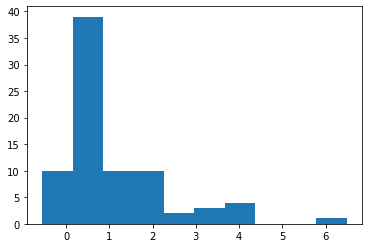

In [22]:
plt.figure()
plt.hist(spk_EMA3['decay_rate'])
plt.show()

In [23]:
print(spk_SMA3.decay_rate.mean())
print(spk_EMA3.decay_rate.mean())

1.0531166390190372
1.0567497962603933


## Exponential Decay

11.996778125075972


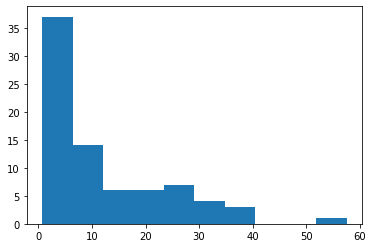

In [24]:
spk_SMA3['lamb'] = 1 / spk_SMA3['days']
spk_SMA3['halflife'] = - np.log(0.5) / spk_SMA3['lamb']

print(spk_SMA3['halflife'].mean())

plt.figure()
plt.hist(spk_SMA3['halflife'])
plt.show()

11.511507606261361


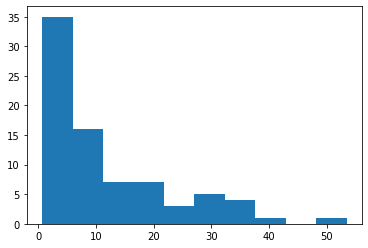

In [25]:
spk_EMA3['lamb'] = 1 / spk_EMA3['days']
spk_EMA3['halflife'] = - np.log(0.5) / spk_EMA3['lamb']

print(spk_EMA3['halflife'].mean())

plt.figure()
plt.hist(spk_EMA3['halflife'])
plt.show()

# Possion distribution

In [26]:
#  Kolmogorov-Smirnov test -> can't reject H0
kstest(spk_number,'poisson',args=(spk_mean,),alternative='two-sided')

KstestResult(statistic=0.18971706911554279, pvalue=0.1885512515051635)

In [27]:
np.random.seed(50)
sim_poisson = poisson.rvs(spk_mean, size=1000)

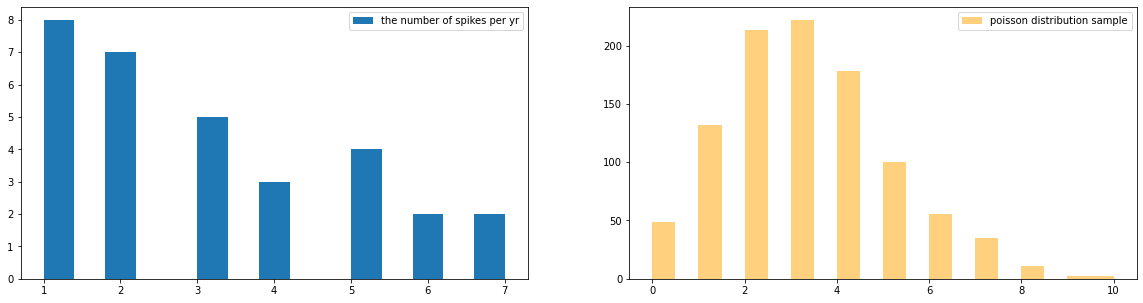

In [28]:
plt.figure(1,figsize=(20,5))
fig1 = plt.subplot(121)
fig1 = plt.hist(spk_number,bins=15,label='the number of spikes per yr')
plt.legend()
fig2 = plt.subplot(122)
fig2 = plt.hist(sim_poisson,bins=20,color='orange',alpha = 0.5,label='poisson distribution sample')
plt.legend()
plt.show()

# Hawkes Processes

$$\lambda_t = \lambda_{0,t} + \sum Y_ie^{-\delta(t-T_i)}$$
$\lambda_{0,t}$:base intensity\
$Y_i$:measure the effect of past events\
$\delta$:decay rate of the event effects on the intensity rate\
To simplify the model , we assume these three parameters are constant.

In [29]:
def HawkesProcess(lam0,Y,delta,T,seed):
    
    np.random.seed(seed)
    
    # First event
    lam_star = lam0
    for i in range(0,1000):
        U1 = np.random.uniform(0,1,1)[0]
        S = -np.log(U1)/lam_star
        if S <= T:
            T1 = S
            break
    
    Ti = []
    Ti.append(T1) # time points of jumps
    lam = []
    lam.append(lam0) # intensity rate
    
    # General routine
    for n in range(0,1000):
        t = Ti[n]
        lam_n_1 = lam0 + Y*sum(np.exp(-delta*(t-pd.Series(Ti)))) # intensity rate of T(n-1)
        lam.append(lam_n_1)
        lam_star = lam_n_1 + Y
        for i in range(0,1000):
            Un = np.random.uniform(0,1,1)[0]
            S = S-np.log(Un)/lam_star
            if S <= T:
                lam_s = lam0 + Y*sum(np.exp(-delta*(S-pd.Series(Ti)))) + Y # intensity rate of t = Sn
                Dn = np.random.uniform(0,1,1)[0]
                if Dn <= lam_s/lam_star:
                    Tn = S
                    Ti.append(Tn)
                    break
                else:
                    lam_star = lam_s
        if len(Ti) < (n+2): # stop when we can't find new Ti
            break
    
    return pd.Series(Ti)

In [30]:
def IntensityRate(lam0,Y,delta,all_t,Ti):
    # all_t: all time points
    # Ti: spike points
    lam = []
    lam.append(lam0)
    for i in range(1,len(all_t)):
        t = all_t[i]
        Ti_t = Ti[Ti<=t]
        lam_t = lam0 + Y*sum(np.exp(-delta*(t-Ti_t)))
        lam.append(lam_t)
    return pd.Series(lam)

In [31]:
T = 32.5
seed = 36
spk_time = ((spk.Date - vix.Date[0]).dt.days/365).reset_index(drop=True)  # time of spikes in yr unit
total_spk = spk_time.count()   # the number of spikes from 1990/01 to 2022/06

In [32]:
# Minimize MSE
MSE = lambda x: np.mean((HawkesProcess(x[0],x[1],x[2],T,seed)-spk_time)**2)
initial_guess = [spk_number.mean(),0.8,1]
res = minimize(MSE, initial_guess, method='Powell')

In [33]:
# parameters: Lambda0,Y,delta
x = res.x
x 

array([0.35910516, 0.79484552, 0.99998703])

In [34]:
all_t = ((vix.Date - vix.Date[0]).dt.days/365).reset_index(drop=True)
real_intensity = IntensityRate(x[0],x[1],x[2],all_t,spk_time)

In [35]:
# simulate 100 possible paths of intensity rate
simulate_intensity = pd.DataFrame()
for i in tqdm(range(0,100)):
    sim_spk_time = HawkesProcess(x[0],x[1],x[2],T,seed+i) # simulated spike timing
    sim_intensity = IntensityRate(x[0],x[1],x[2],all_t,sim_spk_time) # simulated intensity rate
    simulate_intensity[str(seed+i)] = sim_intensity

100%|█████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


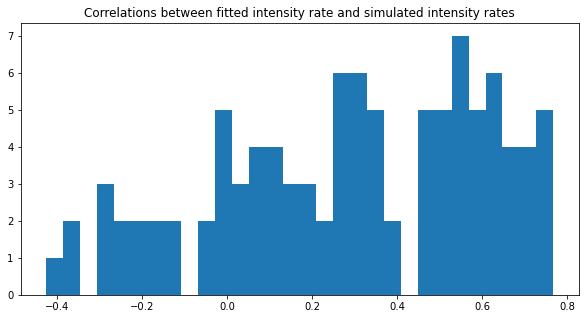

In [36]:
# correlations
corr_intensity = pd.DataFrame(index=simulate_intensity.columns,
                              columns=['Correlations'])
for col in simulate_intensity.columns:
    corr_intensity.loc[col,'Correlations'] = np.corrcoef(simulate_intensity[col],real_intensity)[0,1]

plt.figure(figsize=(10,5))
plt.title('Correlations between fitted intensity rate and simulated intensity rates')
plt.hist(corr_intensity['Correlations'],bins=30)
plt.show()

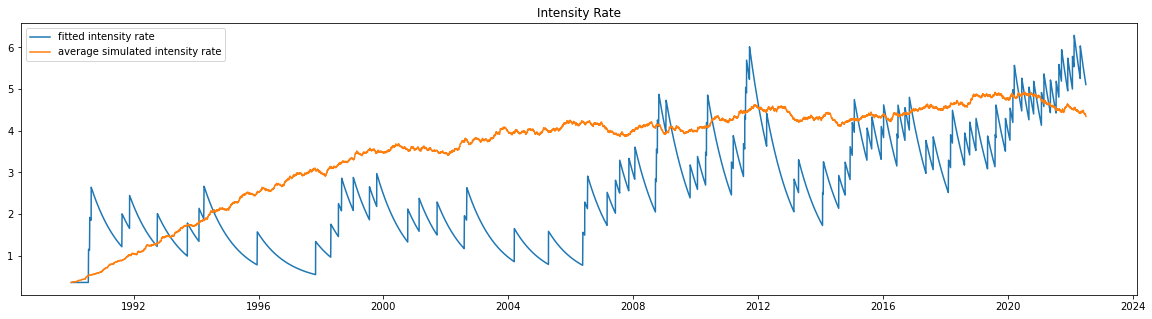

In [37]:
# fitted intensity rate and the average simulated intensity rate
ave_intensity = simulate_intensity.mean(axis=1)
plt.figure(figsize=(20,5))
plt.plot(vix['Date'],real_intensity,label='fitted intensity rate')
plt.plot(vix['Date'],ave_intensity,label='average simulated intensity rate')
plt.title('Intensity Rate')
plt.legend()
plt.show()

In [38]:
charac1 = pd.DataFrame(columns=['fitted intensity rate','average simulated intensity rate'],
                      index=['Mean','std dev','Correlation'])
charac1.iloc[0,0] = real_intensity.mean()
charac1.iloc[0,1] = ave_intensity.mean()
charac1.iloc[1,0] = real_intensity.std()
charac1.iloc[1,1] = ave_intensity.std()
charac1.iloc[2,0] = np.corrcoef(real_intensity,ave_intensity)[0,1]
charac1

,fitted intensity rate,average simulated intensity rate
Mean,2.541486,3.562007
std dev,1.317383,1.168314
Correlation,0.607431,NaN


In [39]:
corr_intensity.sort_values(by='Correlations',ascending=False)

,Correlations
36,0.767533
105,0.765489
44,0.765292
45,0.754194
63,0.729767
...,...
93,-0.276772
67,-0.293244
60,-0.35327
38,-0.377743


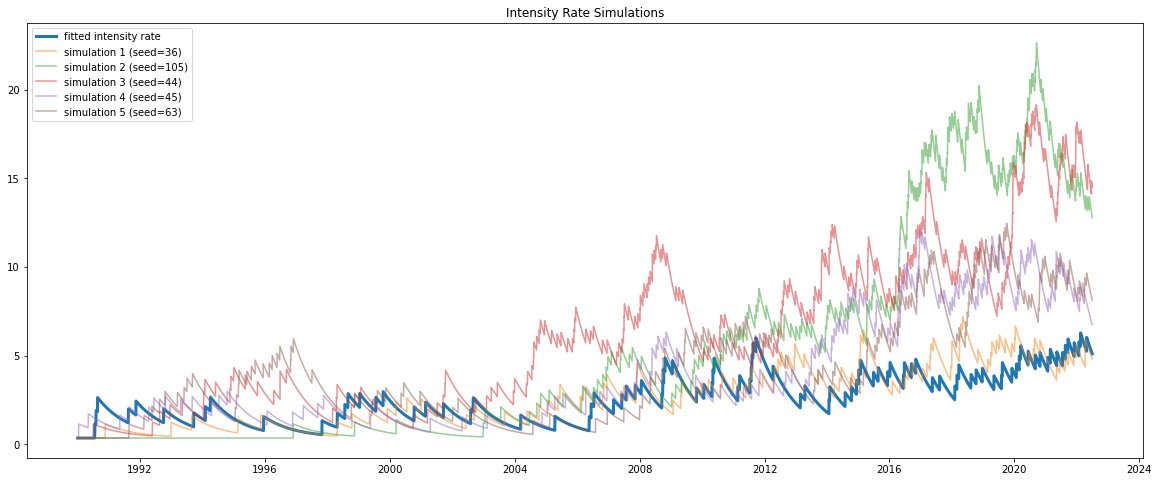

In [40]:
# fitted intensity rate and the 5 closest simulations
plt.figure(figsize=(20,8))
plt.plot(vix['Date'],real_intensity,label='fitted intensity rate',linewidth=3)
plt.plot(vix['Date'],simulate_intensity['36'],label='simulation 1 (seed=36)',alpha=0.5)
plt.plot(vix['Date'],simulate_intensity['105'],label='simulation 2 (seed=105)',alpha=0.5)
plt.plot(vix['Date'],simulate_intensity['44'],label='simulation 3 (seed=44)',alpha=0.5)
plt.plot(vix['Date'],simulate_intensity['45'],label='simulation 4 (seed=45)',alpha=0.5)
plt.plot(vix['Date'],simulate_intensity['63'],label='simulation 5 (seed=63)',alpha=0.5)
plt.title('Intensity Rate Simulations')
plt.legend()
plt.show()

In [41]:
# the seed that maximize the correlation
seed = 36
pred_spk_time = (HawkesProcess(x[0],x[1],x[2],T,seed)*365).round() # simulated spike time
for i in range(0,len(pred_spk_time)):
    pred_spk_time[i] = vix.Date[0]+ datetime.timedelta(days=pred_spk_time[i]) 
pred_spk_time = pd.to_datetime(pred_spk_time.astype('str')) # simulated spike date

In [42]:
pred_spk_time

0    1990-11-20
1    1992-12-28
2    1993-08-26
3    1995-02-21
4    1995-11-14
        ...    
94   2021-09-21
95   2021-11-27
96   2021-12-24
97   2022-04-08
98   2022-04-10
Length: 99, dtype: datetime64[ns]

In [43]:
pred_intensity = IntensityRate(x[0],x[1],x[2],all_t,HawkesProcess(x[0],x[1],x[2],T,seed))

In [44]:
charac2 = pd.DataFrame(columns=['fitted intensity rate','the closest simulation'],
                       index=['Mean','std dev','skew','Correlation'])
charac2.iloc[0,0] = real_intensity.mean()
charac2.iloc[0,1] = pred_intensity.mean()
charac2.iloc[1,0] = real_intensity.std()
charac2.iloc[1,1] = pred_intensity.std()
charac2.iloc[2,0] = real_intensity.skew()
charac2.iloc[2,1] = pred_intensity.skew()
charac2.iloc[3,0] = np.corrcoef(real_intensity,pred_intensity)[0,1]
charac2

,fitted intensity rate,the closest simulation
Mean,2.541486,2.642084
std dev,1.317383,1.645454
skew,0.508241,0.443899
Correlation,0.767533,NaN


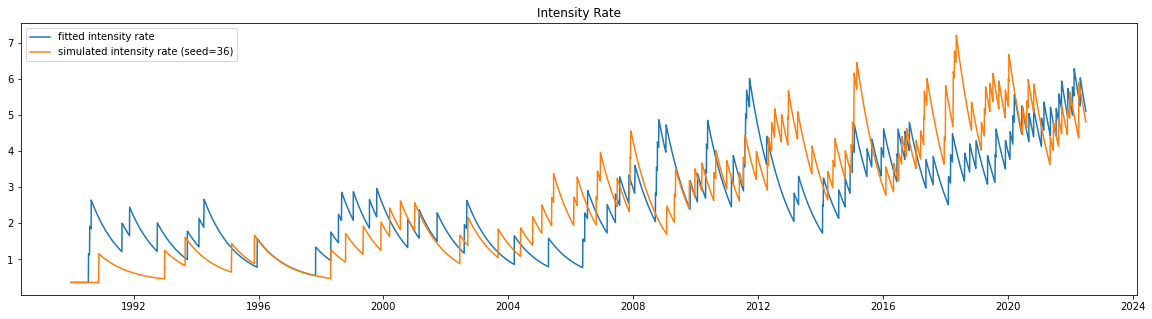

In [45]:
plt.figure(figsize=(20,5))
plt.plot(vix['Date'],real_intensity,label='fitted intensity rate')
plt.plot(vix['Date'],pred_intensity,label='simulated intensity rate (seed=36)')
plt.title('Intensity Rate')
plt.legend()
plt.show()

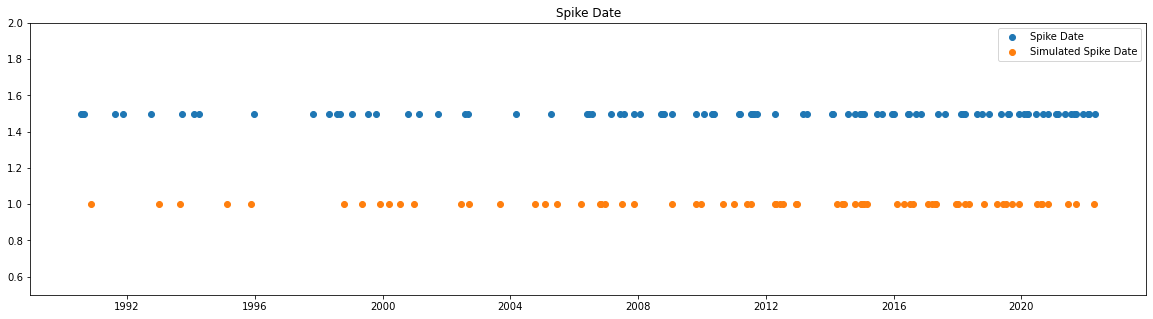

In [46]:
pred_spk = vix.loc[vix.Date.isin(pred_spk_time)]
plt.figure(figsize=(20,5))
plt.scatter(spk['Date'],np.repeat(1.5,len(spk['Date'])),marker='o',label='Spike Date')
plt.scatter(pred_spk['Date'],np.repeat(1,len(pred_spk['Date'])),marker='o',label='Simulated Spike Date')
plt.ylim(0.5,2)
plt.title('Spike Date')
plt.legend()
plt.show()

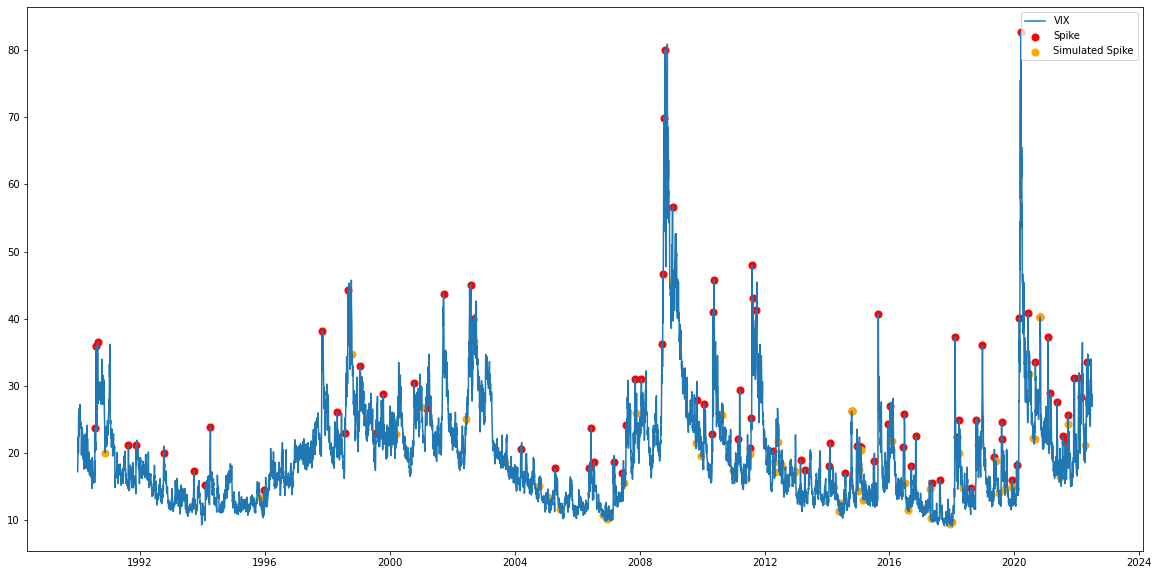

In [47]:
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],vix['VIX'],label='VIX')
plt.scatter(spk['Date'],spk['VIX'],s=50, color='red',label='Spike')
plt.scatter(pred_spk['Date'],pred_spk['VIX'],s=50, color='orange',label='Simulated Spike')
plt.legend()
plt.show()

# SSA

In [48]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        
        # Type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):

        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
    
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):

        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

Text(0.5, 1.0, 'W-Correlation for L = 400')

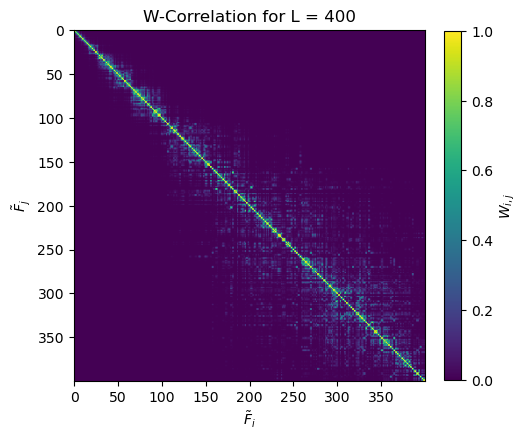

In [49]:
VIX_ssa_L400 = SSA(vix['VIX'], 400)
plt.figure(figsize=(5,5), dpi = 100)
VIX_ssa_L400.plot_wcorr()
plt.title("W-Correlation for L = 400")

In [50]:
VIX_ssa = SSA(vix['VIX'], 200)
vix_separa_1 = pd.DataFrame()
vix_separa_1['Trend'] = VIX_ssa.reconstruct(slice(0,12))
vix_separa_1['Noise'] = VIX_ssa.reconstruct(slice(13,400))
vix_separa_1['Date'] = vix['Date']
vix_separa_1

,Trend,Noise,Date
0,20.867084,-3.668409,1990-01-02
1,21.245879,-3.117228,1990-01-03
2,21.621871,-2.479090,1990-01-04
3,21.989778,-1.963688,1990-01-05
4,22.348403,-2.168653,1990-01-08
...,...,...,...
8182,30.346890,-2.536134,2022-06-24
8183,30.292344,-2.614155,2022-06-27
8184,30.210111,-0.996074,2022-06-28
8185,30.077072,-0.962332,2022-06-29


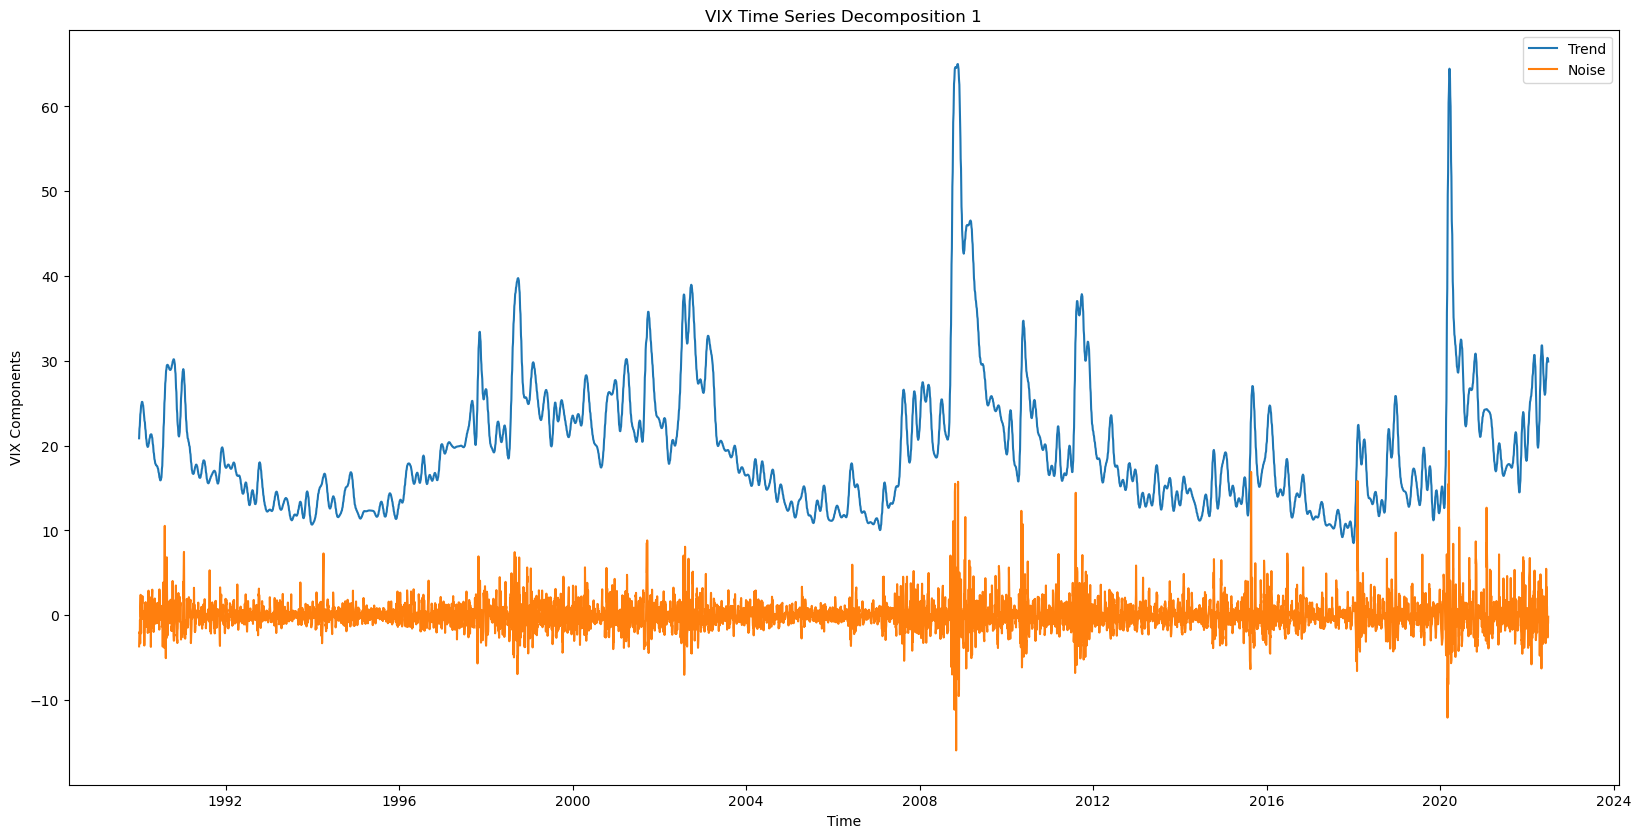

In [51]:
plt.figure(figsize=(20, 10), dpi = 100)
plt.plot(vix_separa_1['Date'],vix_separa_1['Trend'])
plt.plot(vix_separa_1['Date'],vix_separa_1['Noise'])
plt.title("VIX Time Series Decomposition 1")
plt.xlabel("Time")
plt.ylabel("VIX Components")
legend = ["Trend"] + ["Noise"]
plt.legend(legend)
plt.show()

# VIX simualtion

## Part I - mean reverting model

$$dV_t=(\alpha-\beta V_t)dt+\sigma V_t^\gamma dW_t$$
Estimate $\alpha,\beta,\sigma,\gamma$ based on GMM using the trend data splitted from the original VIX.

In [52]:
V = pd.DataFrame(vix_separa_1['Trend'])
V['Vt'] = V.Trend
V['Vt1'] = V.Trend.shift(-1)
V = V.dropna()
V

,Trend,Vt,Vt1
0,20.867084,20.867084,21.245879
1,21.245879,21.245879,21.621871
2,21.621871,21.621871,21.989778
3,21.989778,21.989778,22.348403
4,22.348403,22.348403,22.704741
...,...,...,...
8181,30.352318,30.352318,30.346890
8182,30.346890,30.346890,30.292344
8183,30.292344,30.292344,30.210111
8184,30.210111,30.210111,30.077072


In [53]:
V_t = np.array(V.Vt)  # V(t),exog1
V_t1 = np.array(V.Vt1) # V(t+1),endog
dt = 1/365

In [54]:
class gmm(GMM):
    
    def momcond(self, params):
        alpha,beta,sigma,gamma = params
        endog = self.endog.squeeze() # V(t+1)
        exog = self.exog.squeeze() # V(t)
        inst = self.instrument   
        
        epsilon_t1 = endog - exog - (alpha-beta*exog)*dt # epsilon(t+1)
        
        error1 = epsilon_t1
        error2 = epsilon_t1 * inst[:,1]
        error3 = epsilon_t1**2 - (sigma**2)*(exog**(2*gamma))*dt
        error4 = (epsilon_t1**2 - (sigma**2)*(exog**(2*gamma))*dt) * inst[:,1]
        error5 = (epsilon_t1**3)
        error6 = (epsilon_t1**3)*inst[:,1]
    
        f_theta = np.column_stack((error1, error2, error3, error4, error5, error6))
        
        return f_theta

In [55]:
guess = np.array([10,0.5,0.1,1])
inst = np.column_stack((np.ones(len(V_t)), V_t))
res = gmm(endog=V_t1, exog=V_t, instrument=inst, k_moms=6, k_params=4).fit(guess,wargs=dict(centered=False))
res.model.exog_names[:] = 'alpha beta sigma gamma'.split()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.002125
         Iterations: 93
         Function evaluations: 114
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: 0.006059
         Iterations: 75
         Function evaluations: 84
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: 0.004149
         Iterations: 38
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.004199
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.004199
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
                                 gmm Results                                  
Dep. Variable:                      y   Hansen J:              

## Part II - add jump

In [56]:
spk['ysd_vix'] = vix.iloc[spk_date.index-1].VIX.values
spk['jump_size'] = spk.VIX - spk.ysd_vix
jp_size_mean = spk['jump_size'].mean()
jp_size_std = spk['jump_size'].std()

4.554 4.213191391585203


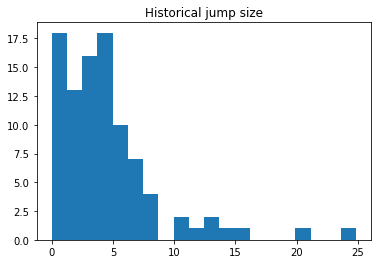

In [57]:
print(jp_size_mean,jp_size_std)
plt.figure()
plt.hist(spk['jump_size'],bins=20)
plt.title('Historical jump size')
plt.show()

In [58]:
SSA = vix_separa_1.copy()

simulate paths based on mean-reverting+jump 

In [59]:
def vix_simulation(V0,dt,alpha,beta,sigma,gamma,seed):
    
    w1 = np.random.normal(0,1,len(SSA)-1)

    spk_time = round(HawkesProcess(x[0],x[1],x[2],T,seed)*365) # predictive spike time
    for i in range(0,len(spk_time)):
        spk_time[i] = vix.Date[0]+ datetime.timedelta(days=spk_time[i])
    spk_time = pd.to_datetime(spk_time.astype('str')) # predictive spike date
    qt = SSA.Date.isin(spk_time)
        
    sim_vix = []
    sim_vix.append(V0)
    
    for i in range(0,len(SSA)-1):
        
        Vt = sim_vix[i]
        if Vt > 0:
            dV1 = (alpha - beta*Vt)*dt + sigma*(Vt**gamma)*np.sqrt(dt)*w1[i]
        else:
            dV1 = (alpha - beta*Vt)*dt - sigma*(abs(Vt)**gamma)*np.sqrt(dt)*w1[i]
            
        jp_size = random.sample(list(spk['jump_size']),1)[0]
        dV2 = jp_size*qt[i+1]
        
        sim_vix.append(Vt+dV1+dV2)
        
    return pd.Series(sim_vix)

In [60]:
V0 = 17.24
dt = 1/365
alpha = 11.7984
beta = 0.7161
sigma = 0.1081
gamma = 1.2125
seed = 36

In [61]:
trend_simulation = pd.DataFrame()
for m in tqdm(range(0,1000)):
    path = vix_simulation(V0,dt,alpha,beta,sigma,gamma,seed)
    trend_simulation[str(m)] = path
    seed = seed+1

100%|███████████████████████████████████████| 1000/1000 [03:25<00:00,  4.86it/s]


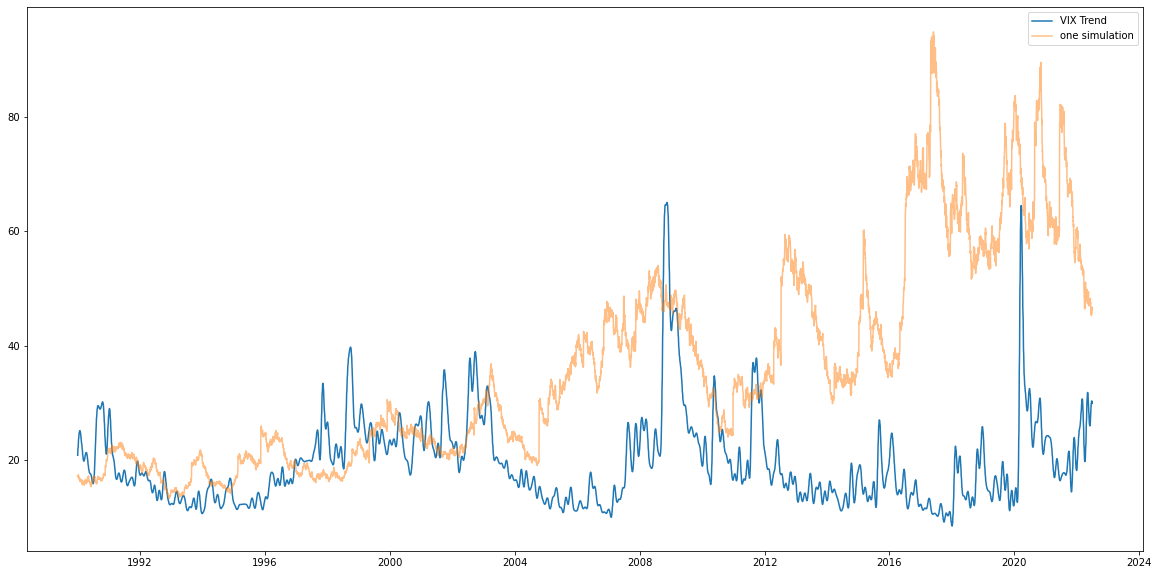

In [62]:
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],SSA['Trend'],label='VIX Trend')
plt.plot(vix['Date'],trend_simulation['0'],alpha=0.5,label='one simulation')
plt.legend()
plt.show()

## Part III - add noise

In [63]:
noise = SSA.Noise
noise # The noise splitted from the original VIX

0      -3.668409
1      -3.117228
2      -2.479090
3      -1.963688
4      -2.168653
          ...   
8182   -2.536134
8183   -2.614155
8184   -0.996074
8185   -0.962332
8186   -0.179871
Name: Noise, Length: 8187, dtype: float64

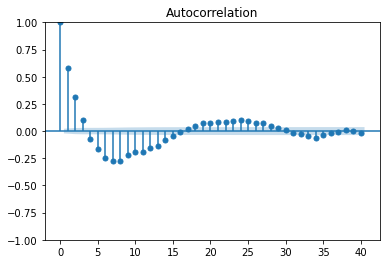

In [64]:
# ACF
plot_acf(noise)
plt.show()

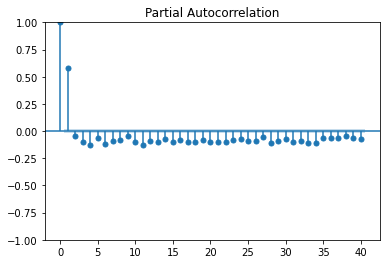

In [65]:
# PACF
plot_pacf(noise)
plt.show()

In [66]:
# Choose ARMA(1,1) according to ACF & PACF
reg = ARIMA(noise, order=(1,0,1))
mod = reg.fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                  Noise   No. Observations:                 8187
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14653.155
Date:                Thu, 25 Aug 2022   AIC                          29314.310
Time:                        12:55:23   BIC                          29342.352
Sample:                             0   HQIC                         29323.897
                               - 8187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.041     -0.057      0.955      -0.082       0.077
ar.L1          0.5451      0.006     85.599      0.000       0.533       0.558
ma.L1          0.0556      0.006      8.792      0.0

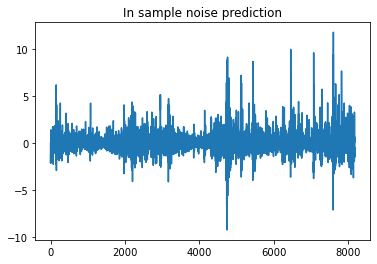

In [67]:
# in sample prediction
pred_noise = mod.predict()
plt.plot(pred_noise)
plt.title('In sample noise prediction')
plt.show()

## final simualtion 

In [68]:
# plus noise to the trend simulation and calculate the correlation between the final simulations and the real VIX
final_simulation = pd.DataFrame(index=trend_simulation.index,columns=trend_simulation.columns)
corr_vix = pd.DataFrame(index=trend_simulation.columns,columns=['Correlation'])
for col in trend_simulation.columns:
    final_simulation[col] = trend_simulation[col] + pred_noise
    path = final_simulation[col]
    corr_vix.loc[col,'Correlation'] = np.corrcoef(path,vix.VIX)[0,1]

In [69]:
final_simulation

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,...,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698,17.237698
1,14.956350,14.956350,14.940560,15.186599,15.142750,15.017518,15.120063,15.269932,14.999897,15.142022,...,15.231127,15.089642,15.299596,15.135459,14.920135,15.244199,15.158303,14.927198,15.127804,14.763869
2,15.320051,15.320051,15.216593,15.643999,15.277113,15.535901,15.879927,15.806472,15.307481,15.602842,...,15.147150,15.237172,15.456214,15.523424,15.643442,15.886123,15.646920,15.670491,15.245693,15.100131
3,15.848283,15.848283,15.752082,16.208234,15.427100,15.833867,16.269540,15.825845,15.613789,15.827812,...,15.382945,15.578275,15.848770,15.679045,16.461591,16.371978,15.997888,16.089788,15.346137,15.673311
4,16.053715,16.053715,16.007199,16.285009,15.822600,16.467566,16.540044,15.953017,16.021102,16.449650,...,15.622065,16.028871,16.300416,15.875231,16.760637,16.789256,16.161089,16.513803,15.917598,15.821392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8182,45.954837,54.606503,47.204247,81.645631,27.889599,85.148801,27.321481,60.746194,101.372311,71.488491,...,30.086241,35.830409,89.822759,55.691374,32.109935,34.158862,112.243417,27.528890,47.872286,46.475989
8183,44.570866,53.130853,47.080622,81.493608,26.735061,84.831534,26.275957,58.876379,100.902544,69.784004,...,29.118420,35.294646,89.114649,54.787881,31.030415,32.977624,113.682310,26.581323,47.151118,45.980163
8184,45.261376,53.974390,46.869043,80.836672,26.495531,85.842140,26.019093,58.461698,100.977734,72.335626,...,29.150612,35.762568,88.594050,55.081305,30.950269,33.226204,110.721911,26.312642,45.605892,46.084069
8185,46.012457,54.671320,47.365968,80.786221,27.333620,85.057796,27.179850,59.735738,101.115356,74.188223,...,29.775709,36.629810,89.101313,55.995963,32.021864,34.407658,110.738403,27.603589,45.901907,46.569487


In [70]:
sort_corr = corr_vix.sort_values(by='Correlation',ascending=False)

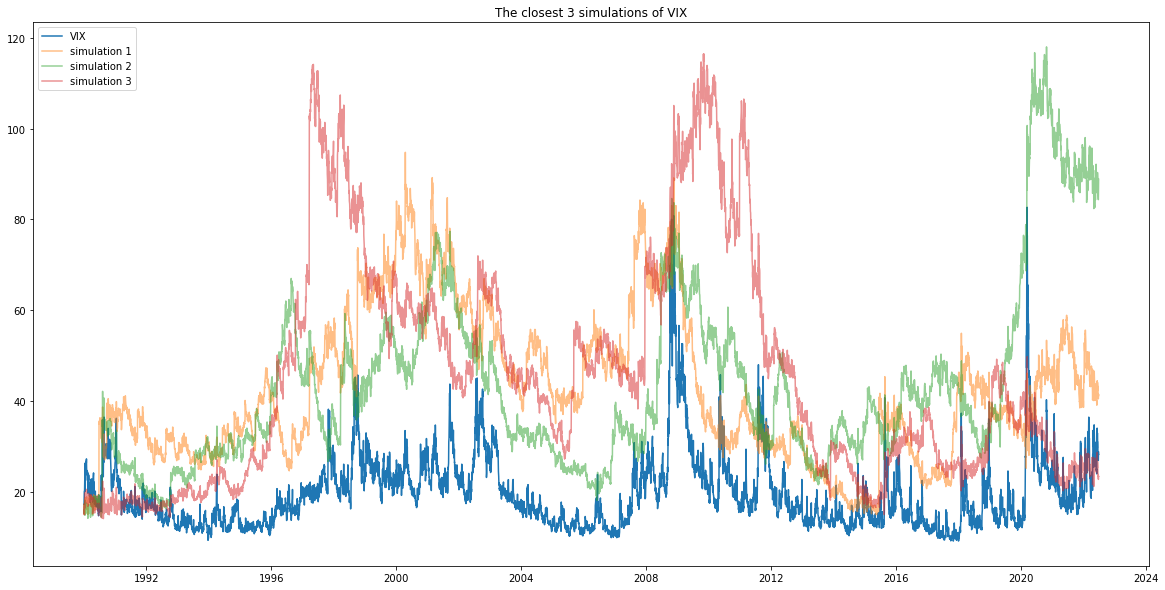

In [71]:
# the closest 3 simulations
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],vix['VIX'],label='VIX')
plt.plot(vix['Date'],final_simulation[sort_corr.index[0]],alpha=0.5,label='simulation 1')
plt.plot(vix['Date'],final_simulation[sort_corr.index[1]],alpha=0.5,label='simulation 2')
plt.plot(vix['Date'],final_simulation[sort_corr.index[2]],alpha=0.5,label='simulation 3')
plt.title('The closest 3 simulations of VIX')
plt.legend()
plt.show()

In [72]:
# For each date, find the closest simulation point to the real VIX
best_simulation = []
for ind in trend_simulation.index:
    all_path = trend_simulation.iloc[ind,:] + pred_noise[ind]
    diff = abs(all_path - vix.VIX[ind])
    pick = (diff == diff.min())
    select_point = all_path[pick]
    best_simulation.append(select_point[0])

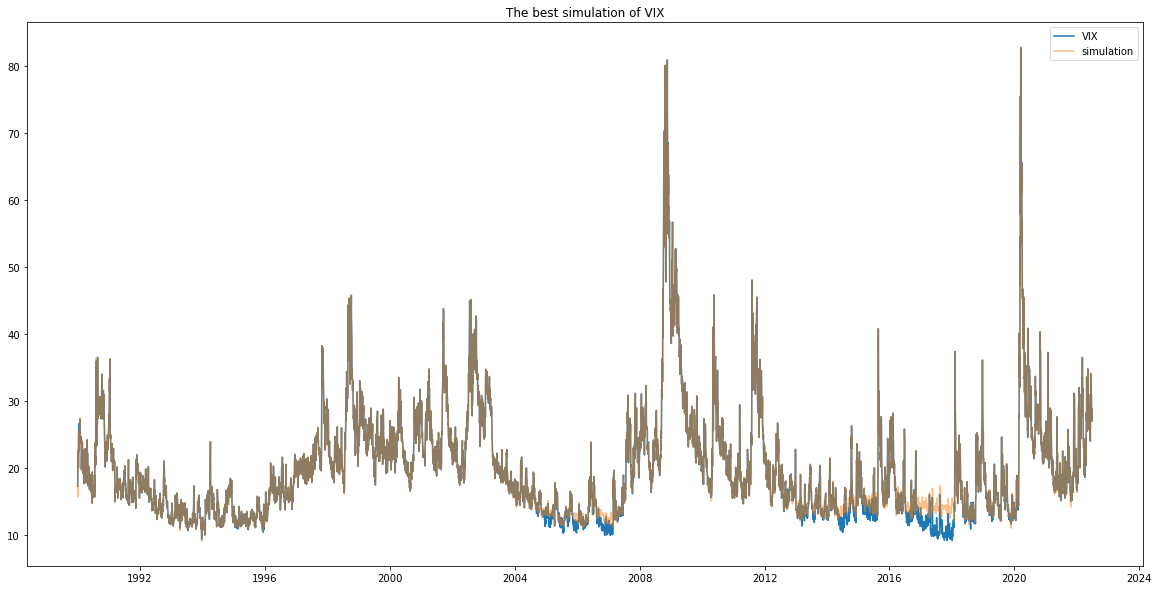

In [73]:
best_simulation= pd.Series(best_simulation)
plt.figure(figsize=(20,10))
plt.plot(vix['Date'],vix['VIX'],label='VIX')
plt.plot(vix['Date'],best_simulation,alpha=0.5,label='simulation')
plt.title('The best simulation of VIX')
plt.legend()
plt.show()

In [74]:
compar = pd.DataFrame(columns=['VIX','Simulation'],index=['Mean','Volatility','Skewness','Correlation'])
compar.loc['Mean','VIX'] = vix.VIX.mean()
compar.loc['Mean','Simulation'] = best_simulation.mean()
compar.loc['Volatility','VIX'] = vix.VIX.std()
compar.loc['Volatility','Simulation'] = best_simulation.std()
compar.loc['Skewness','VIX'] = vix.VIX.skew()
compar.loc['Skewness','Simulation'] = best_simulation.skew()
compar.loc['Correlation','VIX'] = np.corrcoef(best_simulation,vix.VIX)[0,1]

In [75]:
compar

,VIX,Simulation
Mean,19.584611,19.793017
Volatility,8.017596,7.830135
Skewness,2.157962,2.299642
Correlation,0.996314,NaN
